In [48]:
from math import sqrt

import keras
import numpy as np
import pandas as pd
from keras import layers
from keras.callbacks import EarlyStopping
from keras_tuner.tuners import RandomSearch
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
import matplotlib.pyplot as plt
from pydmd import DMD

In [49]:
def read_data(filename = '../data/global_irradiance_daily_aurora.csv'):
    df_temp = pd.read_csv(
        filename,
        sep=';',  # Usando ponto e vírgula como separador
        parse_dates=['Data'],  # Indicando que 'Data' deve ser interpretado como data
        index_col=['Data']  # Usando 'Data' como índice
    )

    # Renomeando a coluna 'Medicao' para 'RADIATION' para manter a consistência
    df_temp.rename(columns={'Medicao': 'RADIATION'}, inplace=True)

    init_index = lambda _df_temp: _df_temp[_df_temp.RADIATION != 0].index[0]

    return df_temp.loc[df_temp.index >= init_index(df_temp)]



def replace_outliers_with_nan(df, column_name='RADIATION', threshold=3):
    
    # Substitui outliers em um DataFrame com NaN com base no z-score.
    
    # Parâmetros:
    #    df (pd.DataFrame): O DataFrame para o qual os outliers devem ser substituídos.
    #    threshold (float): O valor limite do z-score para considerar um ponto como outlier.
        
    # Retorna:
    #    pd.DataFrame: DataFrame com outliers substituídos por NaN.
    
    # Verifica se os dados na coluna especificada são numéricos
    if df[column_name].dtype == object:
        # Tenta converter os dados para numéricos
        try:
            df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
        except ValueError:
            print(f"Erro: Não foi possível converter os dados na coluna {column_name} para numérico.")
            return df
    
    # Verifica se há NaN após a conversão e trata conforme necessário
    if df[column_name].isna().any():
        print(f"Aviso: NaN encontrado na coluna {column_name}.")
        # Aqui você pode adicionar código para tratar os NaN conforme necessário
    
    # Calcula z-scores
    z_scores = np.abs(zscore(df[column_name], nan_policy='omit'))  # 'omit' para ignorar NaN nos cálculos
    
    # Imprime o maior z-score encontrado
    print("Maior z-score encontrado:", np.nanmax(z_scores))  # np.nanmax para ignorar NaN
    
    # Obtém boolean array onde True indica a presença de um outlier
    outliers = (z_scores > threshold)
    
    # Substitui outliers por NaN apenas na coluna especificada
    df_out = df.copy()
    df_out.loc[outliers, column_name] = np.nan
    
    return df_out




def dmd_filler(data: pd.Series):
    column = data.name
    data = data.to_frame()
    filled_data = data.copy()
    matrix_data = filled_data.copy().values.T

    col_mean = np.nanmean(matrix_data, axis=1)
    inds_nan = np.where(np.isnan(matrix_data))
    matrix_data[inds_nan] = np.take(col_mean, inds_nan[0])

    dmd = DMD(svd_rank=matrix_data.shape[0])
    dmd.fit(matrix_data)
    dmd_data = dmd.reconstructed_data.real.T
    filled_data.values[np.isnan(data.values)] = dmd_data[np.isnan(data.values)]

    return filled_data[column]

def interpolate_filler(data):
    return data.interpolate(method ='linear', limit_direction ='backward')




def fill_df(dataframe, filler):
    data = {}
    for column in dataframe.columns:
        data[column] = filler(dataframe[column])
    return pd.DataFrame(data=data, index=dataframe.index.values)

def windowing(dataframe, step_back, step_front) -> (np.array, np.array):
    dataset = dataframe.values
    x, y = [], []
    for i in range(len(dataset) - step_back - step_front):
        j = (i + step_back)
        x.append(dataset[i:j])
        y.append(dataset[j:(j+step_front), 0])

    return np.array(x), np.array(y)

def split_data(x, y, length, ratio=0.8):
    train_size = int(length * 0.9)
    _train_x, _train_y = x[0:train_size], y[0:train_size].reshape(y[0:train_size].shape[0],)
    _test_x, _test_y = x[train_size:], y[train_size:].reshape(y[train_size:].shape[0],)
    return _train_x, _train_y, _test_x, _test_y

def show_error_metrics(real, pred):
    r2 = r2_score(real, pred)
    mse = mean_squared_error(real, pred)
    rmse = sqrt(mean_squared_error(real, pred))
    mae = mean_absolute_error(real, pred)
    mape = mean_absolute_percentage_error(real, pred)

    print('Test R2: %.3f' % r2)
    print('Test MSE: %.3f' % mse)
    print('Test RMSE: %.3f' % rmse)
    print('Test MAE: %.3f' % mae)
    print('Test MAPE: %.3f' % mape)

In [50]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.LSTM(units=hp.Int('units',
                                       min_value=32,
                                       max_value=512,
                                       step=32),
                          return_sequences=True,
                          input_shape=(3, 1)))  # Ajustado para a nova forma dos dados
    model.add(layers.Dropout(rate=hp.Float(
        'dropout',
        min_value=0.0,
        max_value=0.5,
        default=0.25,
        step=0.05,
    )))
    model.add(layers.LSTM(units=hp.Int('units_2',
                                       min_value=32,
                                       max_value=512,
                                       step=32)))
    model.add(layers.Dense(1, activation=hp.Choice('activation', ['relu', 'sigmoid'])))
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(
        hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])))
    return model

def model_search(
        name,
        train_x,
        train_y,
        max_trials=10,
        executions_per_trial=1,
        epochs=10,
        validation_split=0.3
):
    tuner = RandomSearch(
        build_model,
        seed=13418236482,
        objective='val_loss',
        max_trials=max_trials,
        executions_per_trial=executions_per_trial,
        directory='models',
        project_name=name)

    tuner.search_space_summary()

    tuner.search(train_x, train_y,
                 epochs=epochs,
                 validation_split=validation_split)

    return tuner.get_best_hyperparameters()[0]

In [51]:
class Scaler:
    scales: {}
    df: pd.DataFrame
    df_scaled: pd.DataFrame
    scaled: bool

    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()
        self.scales = {}
        for c in df.columns:
            self.scales[c] = MinMaxScaler(feature_range=(0, 1))
        self.scaled = False

    def get_dataframe_scaled(self):
        if self.scaled:
            return self.df_scaled
        self.scaled = True
        self.df_scaled = self.df.copy()
        for c in df.columns:
            self.df_scaled[c] = self.scales[c]\
                .fit_transform(self.df_scaled[c].values.reshape(-1, 1))
        return self.df_scaled

520
Aviso: NaN encontrado na coluna RADIATION.
Maior z-score encontrado: 7.958223595875242
520


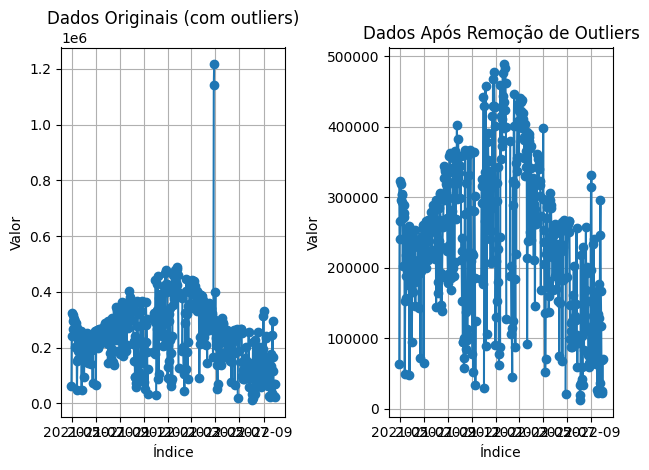

In [52]:

df_init = read_data()

print(df_init.size)
df_no_out = replace_outliers_with_nan(df_init, 'RADIATION')
print(df_no_out.size)

plt.subplot(1, 2, 1)  # 1 linha, 2 colunas, gráfico 1
plt.plot(df_init, marker='o', linestyle='-')
plt.title('Dados Originais (com outliers)')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.grid(True)

# Plotando df_no_out
plt.subplot(1, 2, 2)  # 1 linha, 2 colunas, gráfico 2
plt.plot(df_no_out, marker='o', linestyle='-')
plt.title('Dados Após Remoção de Outliers')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.grid(True)

# Ajustando o layout para evitar sobreposição
plt.tight_layout()
plt.show()

df = fill_df(df_no_out, dmd_filler)




In [53]:
scaler = Scaler(df)
df_scaled = scaler.get_dataframe_scaled()
print(df, df_scaled)

                RADIATION
2021-04-29   63016.275273
2021-04-30  322514.915680
2021-05-01  240170.574569
2021-05-02  266349.735046
2021-05-03  318577.535594
...                   ...
2022-09-26  117538.885685
2022-09-27   25423.149783
2022-09-28   69594.622168
2022-09-29   22021.663290
2022-09-30   70677.632210

[520 rows x 1 columns]             RADIATION
2021-04-29   0.128917
2021-04-30   0.659794
2021-05-01   0.491336
2021-05-02   0.544892
2021-05-03   0.651739
...               ...
2022-09-26   0.240458
2022-09-27   0.052010
2022-09-28   0.142375
2022-09-29   0.045051
2022-09-30   0.144591

[520 rows x 1 columns]


In [54]:
X, Y = windowing(df_scaled, 3, 1)
train_x, train_y, test_x, test_y = split_data(X, Y, length=len(df_scaled), ratio=0.9)

## LSTM

In [55]:
hp = model_search('dmd_lstm_3_1_aurora', train_x, train_y, 20, 5, 10, 0.3)
hp.values

Trial 20 Complete [00h 01m 08s]
val_loss: 0.03248514533042908

Best val_loss So Far: 0.025620876625180245
Total elapsed time: 00h 18m 46s


{'units': 32,
 'dropout': 0.05,
 'units_2': 512,
 'activation': 'sigmoid',
 'learning_rate': 0.01}

Epoch 1/200
7/7 - 3s - loss: 0.0587 - val_loss: 0.0449 - 3s/epoch - 419ms/step
Epoch 2/200
7/7 - 0s - loss: 0.0491 - val_loss: 0.0290 - 134ms/epoch - 19ms/step
Epoch 3/200
7/7 - 0s - loss: 0.0440 - val_loss: 0.0342 - 134ms/epoch - 19ms/step
Epoch 4/200
7/7 - 0s - loss: 0.0401 - val_loss: 0.0419 - 124ms/epoch - 18ms/step
Epoch 5/200
7/7 - 0s - loss: 0.0371 - val_loss: 0.0284 - 131ms/epoch - 19ms/step
Epoch 6/200
7/7 - 0s - loss: 0.0336 - val_loss: 0.0371 - 141ms/epoch - 20ms/step
Epoch 7/200
7/7 - 0s - loss: 0.0349 - val_loss: 0.0280 - 130ms/epoch - 19ms/step
Epoch 8/200
7/7 - 0s - loss: 0.0345 - val_loss: 0.0265 - 133ms/epoch - 19ms/step
Epoch 9/200
7/7 - 0s - loss: 0.0336 - val_loss: 0.0267 - 126ms/epoch - 18ms/step
Epoch 10/200
7/7 - 0s - loss: 0.0339 - val_loss: 0.0260 - 134ms/epoch - 19ms/step
Epoch 11/200
7/7 - 0s - loss: 0.0347 - val_loss: 0.0267 - 110ms/epoch - 16ms/step
Epoch 12/200
7/7 - 0s - loss: 0.0337 - val_loss: 0.0299 - 108ms/epoch - 15ms/step
Epoch 13/200
7/7 - 0s - los

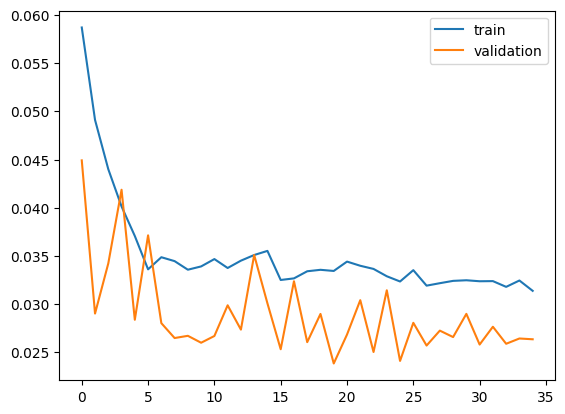

In [56]:
model = build_model(hp)

# fit network
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
history = model.fit(train_x,
                    train_y,
                    epochs=200,
                    batch_size=72,
                    validation_data=(test_x, test_y),
                    validation_split=0.3,
                    verbose=2,
                    callbacks=[es],
                    workers=4,
                    use_multiprocessing=True)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

In [57]:
predict = model.predict(test_x)

real = scaler.scales['RADIATION'].inverse_transform(test_y.reshape(-1,1))
predict = scaler.scales['RADIATION'].inverse_transform(predict)

[polymorphic_function.py:156 -  called_with_tracing() ] 5 out of the last 9 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000175CC6CBA60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 [==============================] - 0s 0s/step


Test R2: -0.087
Test MSE: 6296284029.777
Test RMSE: 79349.127
Test MAE: 64328.268
Test MAPE: 0.920


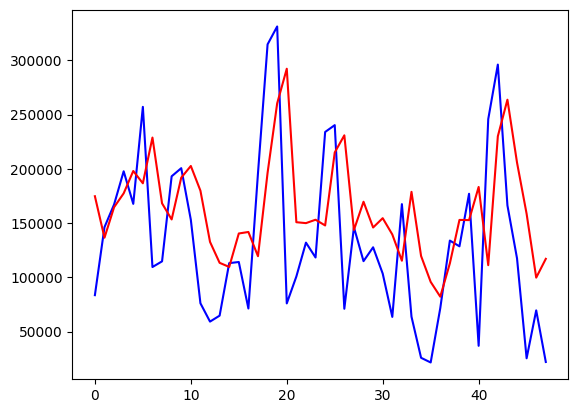

In [58]:
range_plot = 100

pyplot.plot(real[0:range_plot], color='blue', label='real')
pyplot.plot(predict[0:range_plot], color='red', label='incompleto')

show_error_metrics(real, predict)

pyplot.show()

## Manual Model

In [59]:
print(test_x.shape, test_y.shape)

(48, 3, 1) (48,)


Epoch 1/200
5/5 - 2s - loss: 0.0775 - val_loss: 0.0376 - 2s/epoch - 308ms/step
Epoch 2/200
5/5 - 0s - loss: 0.0459 - val_loss: 0.0368 - 90ms/epoch - 18ms/step
Epoch 3/200
5/5 - 0s - loss: 0.0431 - val_loss: 0.0289 - 63ms/epoch - 13ms/step
Epoch 4/200
5/5 - 0s - loss: 0.0393 - val_loss: 0.0247 - 125ms/epoch - 25ms/step
Epoch 5/200
5/5 - 0s - loss: 0.0393 - val_loss: 0.0350 - 123ms/epoch - 25ms/step
Epoch 6/200
5/5 - 0s - loss: 0.0384 - val_loss: 0.0258 - 109ms/epoch - 22ms/step
Epoch 7/200
5/5 - 0s - loss: 0.0372 - val_loss: 0.0276 - 88ms/epoch - 18ms/step
Epoch 8/200
5/5 - 0s - loss: 0.0365 - val_loss: 0.0257 - 65ms/epoch - 13ms/step
Epoch 9/200
5/5 - 0s - loss: 0.0360 - val_loss: 0.0286 - 63ms/epoch - 13ms/step
Epoch 10/200
5/5 - 0s - loss: 0.0374 - val_loss: 0.0245 - 63ms/epoch - 13ms/step
Epoch 11/200
5/5 - 0s - loss: 0.0361 - val_loss: 0.0302 - 63ms/epoch - 13ms/step
Epoch 12/200
5/5 - 0s - loss: 0.0352 - val_loss: 0.0255 - 67ms/epoch - 13ms/step
Epoch 13/200
5/5 - 0s - loss: 0.035

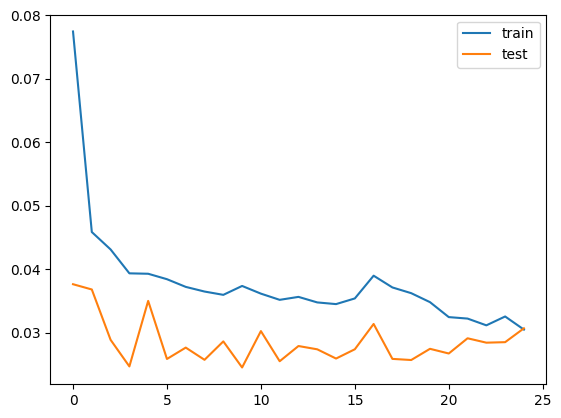

In [60]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM, InputLayer
from keras.callbacks import EarlyStopping


model2 = Sequential([
    Dense(1, input_shape=(3, 1)),
    Dense(units=352),
    Dropout(rate=0.35),
    LSTM(units=320),
    Dense(1, activation='sigmoid')
])


model2.compile(loss='mean_squared_error', optimizer=keras.optimizers.legacy.Adam(0.01))


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
history = model2.fit(train_x,
                     train_y,
                     epochs=200,
                     batch_size=72,
                     #validation_data=(test_x, test_y),
                     validation_split=0.3,
                     verbose=2,
                     callbacks=[es],
                     workers=4,
                     use_multiprocessing=True)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [61]:
model2.evaluate(test_x, test_y, verbose=1)

2/2 [==============================] - 0s 8ms/step - loss: 0.0372


0.03720561042428017

In [62]:
predict = model2.predict(test_x)


real = scaler.scales['RADIATION'].inverse_transform(test_y.reshape(-1,1))
predict = scaler.scales['RADIATION'].inverse_transform(predict)

[polymorphic_function.py:156 -  called_with_tracing() ] 6 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000175CC6CB560> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 [==============================] - 1s 0s/step


Test R2: -0.534
Test MSE: 8889794784.450
Test RMSE: 94285.708
Test MAE: 78782.331
Test MAPE: 1.189


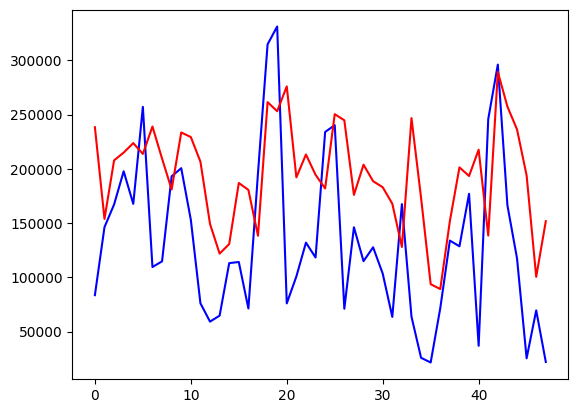

In [63]:
range_plot = 100

pyplot.plot(real[0:range_plot], color='blue', label='real')
pyplot.plot(predict[0:range_plot], color='red', label='incompleto')

show_error_metrics(real, predict)

pyplot.show()

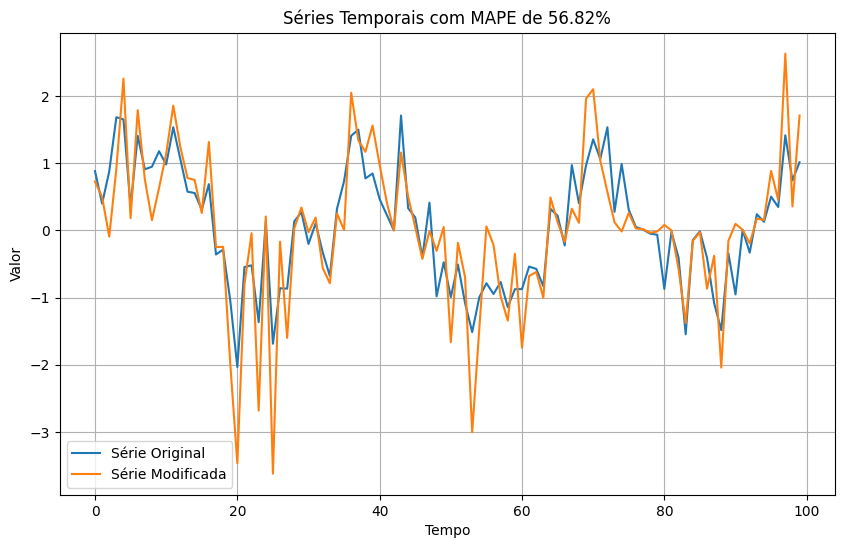

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Gerar uma série temporal de exemplo
np.random.seed(0)  # para reprodutibilidade
time = np.arange(100)
original_series = np.sin(time / 5) + np.random.normal(scale=0.5, size=100)

# Criar uma segunda série temporal com um MAPE de 30% distribuído aleatoriamente
noise = 1 + (np.random.rand(100) - 0.5) * 2.3  # ruído aleatório entre 0.7 e 1.3
modified_series = original_series * noise

# Calcular o MAPE entre as duas séries
mape = np.mean(np.abs((original_series - modified_series) / original_series)) * 100

# Plotar as duas séries temporais
plt.figure(figsize=(10, 6))
plt.plot(time, original_series, label='Série Original')
plt.plot(time, modified_series, label='Série Modificada')
plt.title(f'Séries Temporais com MAPE de {mape:.2f}%')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()
